# Project: Twitter Account WeRateDogs

In this project, the tweet archive of Twitter user @dog_rates, also known as WeRateDogs will be wrangled and analyzed. This account rates people's dogs with a humorous comment about the dog and typically a rating out of 10. WeRateDogs asks people to send photos of their dogs which are rated on a scale of one to ten, but are invariably given ratings that exceeds the maximum.

## Steps

- Data wrangling, which consists of:
 - Gathering data
 - Assessing data
 - Cleaning data
- Storing, analyzing, and visualizing our wrangled data
- Reporting on 1) our data wrangling efforts and 2) our data analyses and visualizations

## Gather

Gather 3 pieces of data:
- Enhanced WeRateDogs Twitter archive: twitter_archive_enhanced.csv
- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Additional data via the Twitter API: Query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
from collections import Counter
import re
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read twitter archive as a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#Use Requests library to download image predictions tsv file
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

#Read image predictions tsv file as a pandas dataframe   
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [4]:
#Access Twitter API
#NOTE: Personal API keys, secrets, and tokens have been replaced with placeholders
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [5]:
#Create a for loop to add each tweet to a new line of tweet json.txt
with open('tweet_json.txt', 'w', encoding='utf8') as f:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

Rate limit reached. Sleeping for: 762
Rate limit reached. Sleeping for: 763


In [6]:
#Create a for loop to append each tweet into a list
tweets_data = []
tweet_file = open('tweet_json.txt', "r")
for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
tweet_file.close()

In [7]:
#Create tweets json dataframe
tweets_json = pd.DataFrame()

In [8]:
#Select variables of interest to the tweets json dataframe
tweets_json['id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweets_json['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweets_json['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

## Assess
After gathering data from a csv file, tsv file, and Twitter's API, the data was later assessed for quality and tidiness issues.

In [9]:
#View a sample of twitter archive
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
581,800443802682937345,NaN,NaN,2016-11-20 21:00:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sampson. He's about to ...,7.761133e+17,4.196984e+09,2016-09-14 17:40:06 +0000,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,None,None,pupper,None
303,836397794269200385,NaN,NaN,2017-02-28 02:09:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Buddy. He ran into a gl...,8.178278e+17,4.196984e+09,2017-01-07 20:18:46 +0000,https://twitter.com/dog_rates/status/817827839...,13,10,Buddy,None,None,None,None
1645,683849932751646720,NaN,NaN,2016-01-04 03:18:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jiminy. He's not the brightest dog. Ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683849932...,5,10,Jiminy,None,None,None,None
1847,675820929667219457,NaN,NaN,2015-12-12 23:34:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a handful of sleepy puppers. All look u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675820929...,11,10,None,None,None,None,None
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827...,10,10,the,None,None,None,None


In [10]:
#View a sample of image predictions
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
410,673887867907739649,https://pbs.twimg.com/media/CVoha_IU4AAZ7vi.jpg,2,Brabancon_griffon,0.216767,True,Chihuahua,0.190958,True,golden_retriever,0.163288,True
847,695409464418041856,https://pbs.twimg.com/media/CaaXN5LUYAEzAh-.jpg,1,pug,0.997445,True,bull_mastiff,0.001749,True,Pekinese,0.000304,True
560,677716515794329600,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,teddy,0.662908,False,crib,0.031891,False,chow,0.025438,True
1459,778027034220126208,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True
408,673711475735838725,https://pbs.twimg.com/media/CVmA_osW4AArAU1.jpg,1,Maltese_dog,0.607401,True,toy_poodle,0.143836,True,Sealyham_terrier,0.063907,True


In [11]:
#View a sample of tweets json
tweets_json.sample(5)

,id,retweet_count,favorite_count
2116,669993076832759809,81,318
336,831552930092285952,2346,9124
1775,676975532580409345,1060,2765
1173,717009362452090881,971,3277
2211,668154635664932864,298,480


In [12]:
#View twitter archive info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
#View descriptive statistics for twitter archive
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
#View image predictions info
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
#View descriptive statistics for image predictions
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
#View tweets json info
tweets_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [17]:
#View descriptive statistics for tweets json
tweets_json.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2737.354354,7644.734449
std,6.823170e+16,4628.986978,11861.010868
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,553.500000,1335.500000
50%,7.182469e+17,1286.000000,3328.000000
75%,7.986692e+17,3185.500000,9379.000000
max,8.924206e+17,78763.000000,158097.000000


In [18]:
#Check for duplicate tweet ids in twitter archive
sum(twitter_archive.tweet_id.duplicated())

0

In [19]:
#Check for duplicate tweet ids in image predictions
sum(image_predictions.tweet_id.duplicated())

0

In [20]:
#check duplicates ids in tweets json
sum(tweets_json.id.duplicated())

0

In [21]:
#check the rating numerator in the twitter archive
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
#check the rating denominator in the twitter archive
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [23]:
# Sort the 'name' column alphabetically in the twitter archive; the lowercase values appear at the bottom
twitter_archive.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1031     very
773      very
1097     very
819      very
1385     very
Name: name, Length: 2356, dtype: object

In [24]:
sum(twitter_archive.name == "None")

745

In [25]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Assessing Summary

### Quality:
- In the twitter_archive table, some dog names are missing (labeled as 'None')
- In the twitter_archive table, there are incorrect dog names
- In the twitter_archive table, there are retweets
- In the twitter_archive table, the timestamp column is a string instead of date/datetime/timestamp
- In the twitter_archive table, the sources are not readable
- In the twitter_archive table, the texts contain links
- In the twitter_archive table, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, source, retweeted_status_user_id, and retweeted_status_timestamp are not needed and need to be removed
- In the tweets_json table, the 'id' column name does not match the name in the other 2 tables
- In the image_predictions, there are tweets with no images
- In the image_predictions table, some of the dog breeds are lowercase instead of uppercase

### Tidiness:
- In the twitter_archive table, the dog "stage" variable is in four columns (doggo, floofer, pupper, puppo) instead of one
- 3 separate datasets which should be combined into one

## Clean
Fix the quality and tidiness issues that were identified in the assessment

In [26]:
#Create copies of the original dataframes
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweets_json_clean = tweets_json.copy()

### Quality
#### In the twitter_archive table, some dog names are missing (labeled as 'None')
#### Define
Remove rows the dog names as 'None' in twitter_archive
#### Code

In [27]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.name != 'None']

#### Test

In [28]:
sum(twitter_archive_clean.name == 'None')

0

#### In the twitter_archive table, there are incorrect dog names
#### Define
Remove rows with incorrect dog names in twitter_archive
#### Code

In [29]:
#Find the upper case names in twitter_archive and determine if they are not genuine names
up = []

for x in twitter_archive_clean['name']:
    if x.isupper():
         up.append(x)
            
up            

['O', 'JD']

In [30]:
#Find the lower case names in twitter_archive and confirm they are not real names
low = []

for x in twitter_archive_clean['name']:
    if x.islower():
         low.append(x)
            
Counter(low)

Counter({'such': 1,
         'a': 55,
         'quite': 4,
         'not': 2,
         'one': 4,
         'incredibly': 1,
         'mad': 2,
         'an': 7,
         'very': 5,
         'just': 4,
         'my': 1,
         'his': 1,
         'actually': 2,
         'getting': 2,
         'this': 1,
         'unacceptable': 1,
         'all': 1,
         'old': 1,
         'infuriating': 1,
         'the': 8,
         'by': 1,
         'officially': 1,
         'life': 1,
         'light': 1,
         'space': 1})

In [31]:
#Keep only the names where the first letter is uppercase
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.name.map(lambda word: word.istitle())]

In [32]:
#Remove the row with the dog name 'O'
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.name != 'O']

#### Test

In [33]:
up = []

for x in twitter_archive_clean['name']:
    if x.isupper():
         up.append(x)
            
low = []

for x in twitter_archive_clean['name']:
    if x.islower():
         low.append(x)
            
up, low

([], [])

#### In the twitter_archive table, there are retweets
#### Define
Remove rows with retweets in twitter_archive
#### Code

In [34]:
#Select rows where retweeted_status_id is null in twitter_archive
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

#### Test

In [35]:
twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### In the twitter_archive table, the timestamp column is a string instead of date/datetime/timestamp
#### Define
Convert timestamp column from string to datetime in twitter_archive
#### Code

In [36]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [37]:
twitter_archive_clean['timestamp'].dtype

datetime64[ns, UTC]

#### In the twitter_archive table, the sources are not readable
#### Define
Make the sources readable by removing the html tags in twitter_archive
#### Code

In [38]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace(r'<[^<]+?>', '')

#### Test

In [39]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     1318
Vine - Make a Scene      41
Twitter Web Client       16
TweetDeck                 9
Name: source, dtype: int64

#### In the twitter_archive table, the texts contain links
#### Define
Remove the links in the texts in twitter_archive
#### Code

In [40]:
twitter_archive_clean['text'] = twitter_archive_clean['text'].replace(r'http\S+', '', regex=True)

#### Test

In [41]:
sum(twitter_archive_clean.text == '')

0

#### In the twitter_archive table, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, source, retweeted_status_user_id, and retweeted_status_timestamp are not needed and need to be removed
#### Define
Drop these columns
#### Code

In [42]:
twitter_archive_clean= twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
                    'retweeted_status_id', 'source', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1) 

#### Test

In [43]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 2325
Data columns (total 11 columns):
tweet_id              1384 non-null int64
timestamp             1384 non-null datetime64[ns, UTC]
text                  1384 non-null object
expanded_urls         1384 non-null object
rating_numerator      1384 non-null int64
rating_denominator    1384 non-null int64
name                  1384 non-null object
doggo                 1384 non-null object
floofer               1384 non-null object
pupper                1384 non-null object
puppo                 1384 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 129.8+ KB


#### In the tweets_json table, the 'id' column name does not match the name in the other 2 tables 
#### Define
Rename the id column into tweet_id in tweets_json
#### Code

In [44]:
tweets_json_clean = tweets_json_clean.rename(columns = {'id':'tweet_id'})

#### Test

In [45]:
tweets_json_clean.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7789,36595


#### In the image_predictions table, there are tweets with no images
#### Define
Remove rows without pictures in image_predictions
#### Code

In [46]:
image_predictions_clean = image_predictions_clean.dropna(subset = ['jpg_url'])

#### Test

In [47]:
image_predictions_clean[image_predictions_clean['jpg_url'].isnull()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### In the image_predictions table, some of the dog breeds are lowercase instead of uppercase
#### Define
Make the first letter uppercase in p1, p2, p3 columns in image_predictions
#### Code

In [48]:
image_predictions_clean['p1'] = image_predictions_clean.p1.str.title()
image_predictions_clean['p2'] = image_predictions_clean.p2.str.title()
image_predictions_clean['p3'] = image_predictions_clean.p3.str.title()

#### Test

In [49]:
one = image_predictions_clean['p1'].str.istitle().value_counts()
two = image_predictions_clean['p2'].str.istitle().value_counts()
three = image_predictions_clean['p3'].str.istitle().value_counts()
one, two, three

(True    2075
 Name: p1, dtype: int64, True    2075
 Name: p2, dtype: int64, True    2075
 Name: p3, dtype: int64)

### Tidiness
#### In the twitter_archive table, the dog "stage" variable is in four columns (doggo, floofer, pupper, puppo) instead of one
#### Define
Create dog stage column and remove the individual dog stage columns in twitter_archive
#### Code

In [50]:
#Given that some of the dogs have multiple stages, the columns will need to be concatenated
twitter_archive_clean.loc[twitter_archive_clean.doggo == 'None', 'doggo'] = ''
twitter_archive_clean.loc[twitter_archive_clean.floofer == 'None', 'floofer'] = ''
twitter_archive_clean.loc[twitter_archive_clean.pupper == 'None', 'pupper'] = ''
twitter_archive_clean.loc[twitter_archive_clean.puppo == 'None', 'puppo'] = ''
twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1200
1,,,,puppo,16
2,,,pupper,,121
3,,floofer,,,5
4,doggo,,,,38
5,doggo,,pupper,,4


In [51]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == '', 'dog_stage'] = 'None'

In [52]:
#Drop the columns no longer needed
columns = ['doggo', 'floofer', 'pupper', 'puppo']
twitter_archive_clean = twitter_archive_clean.drop(columns, axis=1)

#### Test

In [53]:
twitter_archive_clean.dog_stage.value_counts()

None            1200
pupper           121
doggo             38
puppo             16
floofer            5
doggo,pupper       4
Name: dog_stage, dtype: int64

#### 3 separate datasets which should be combined into one
#### Define
Merge the 3 dataframes by tweet_id
#### Code

In [54]:
twitter_ = pd.merge(twitter_archive_clean, image_predictions_clean, on = 'tweet_id', how='left')
twitter = pd.merge(twitter_, tweets_json_clean, on = 'tweet_id', how='left')

#### Test

In [55]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 1383
Data columns (total 21 columns):
tweet_id              1384 non-null int64
timestamp             1384 non-null datetime64[ns, UTC]
text                  1384 non-null object
expanded_urls         1384 non-null object
rating_numerator      1384 non-null int64
rating_denominator    1384 non-null int64
name                  1384 non-null object
dog_stage             1384 non-null object
jpg_url               1343 non-null object
img_num               1343 non-null float64
p1                    1343 non-null object
p1_conf               1343 non-null float64
p1_dog                1343 non-null object
p2                    1343 non-null object
p2_conf               1343 non-null float64
p2_dog                1343 non-null object
p3                    1343 non-null object
p3_conf               1343 non-null float64
p3_dog                1343 non-null object
retweet_count         1377 non-null float64
favorite_count    

### Store Clean Data

In [56]:
twitter.to_csv('twitter.csv')

## Analysis & Visualization

In [57]:
#Check for possible duplicates
sum(twitter.tweet_id.duplicated())

0

In [58]:
#Check for columns with null values
twitter.columns[twitter.isnull().any()]

Index(['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

In [59]:
#Drop all null values
twitter = twitter.dropna()

In [60]:
#Convert dog_stage column to the category data type
twitter['dog_stage'] = twitter['dog_stage'].astype('category')
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 0 to 1383
Data columns (total 21 columns):
tweet_id              1336 non-null int64
timestamp             1336 non-null datetime64[ns, UTC]
text                  1336 non-null object
expanded_urls         1336 non-null object
rating_numerator      1336 non-null int64
rating_denominator    1336 non-null int64
name                  1336 non-null object
dog_stage             1336 non-null category
jpg_url               1336 non-null object
img_num               1336 non-null float64
p1                    1336 non-null object
p1_conf               1336 non-null float64
p1_dog                1336 non-null object
p2                    1336 non-null object
p2_conf               1336 non-null float64
p2_dog                1336 non-null object
p3                    1336 non-null object
p3_conf               1336 non-null float64
p3_dog                1336 non-null object
retweet_count         1336 non-null float64
favorite_count  

In [61]:
#Descriptive statistics
twitter.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
count,1.336000e+03,1336.000000,1336.000000,1336.000000,1336.000000,1.336000e+03,1.336000e+03,1336.000000,1336.000000
mean,7.444818e+17,12.116766,10.028443,1.211078,0.600690,1.339777e-01,6.054467e-02,2447.681886,8744.322605
std,6.879117e+16,48.379336,1.097808,0.575711,0.273879,1.007926e-01,5.172723e-02,3672.761720,11317.620751
min,6.664188e+17,2.000000,7.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,18.000000,98.000000
25%,6.801045e+17,10.000000,10.000000,1.000000,0.366344,5.161850e-02,1.545355e-02,627.750000,2173.250000
50%,7.240255e+17,11.000000,10.000000,1.000000,0.599557,1.183700e-01,4.919990e-02,1374.500000,4457.000000
75%,8.011283e+17,12.000000,10.000000,1.000000,0.868584,1.978287e-01,9.418350e-02,2957.750000,11317.750000
max,8.924206e+17,1776.000000,50.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,57453.000000,122066.000000


## What is the Most Common Rating?

In [62]:
#Create a data frame with rating denominators equal to 10
twitter = twitter[twitter.rating_denominator ==  10]

In [63]:
#Test
twitter.rating_denominator.value_counts()

10    1333
Name: rating_denominator, dtype: int64

In [64]:
twitter.rating_numerator.value_counts()

12      322
11      299
10      269
13      172
9       100
8        70
7        32
14       17
6        17
5        14
3        10
4         5
2         3
1776      1
75        1
27        1
Name: rating_numerator, dtype: int64

#### Most tweets are given a rating between 10 to 13. Moreover, the most common rating is 12/10, followed by 11/10, 10/10, and 13/10. The outliers are 1776/10, 75/10, and 27/10.

Text(0.5, 1.0, 'Distribution of Rating Numerators between 0 to 14')

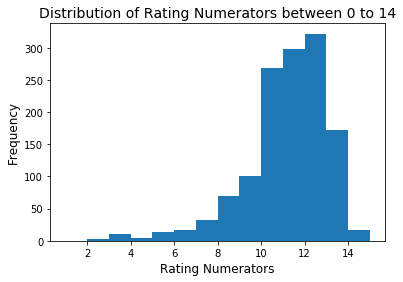

In [65]:
#Create a histogram for distribution of rating numerators between 2 to 14
plt.hist(twitter['rating_numerator'], range = (1, 15), bins= 14)
plt.xlabel('Rating Numerators', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Rating Numerators between 0 to 14', fontsize=14)

#### The rating distribution is left-skewed and peaks at 12.

## What is the Most Common Dog?

In [66]:
twitter.dog_stage.value_counts()

None            1157
pupper           117
doggo             35
puppo             15
floofer            5
doggo,pupper       4
Name: dog_stage, dtype: int64

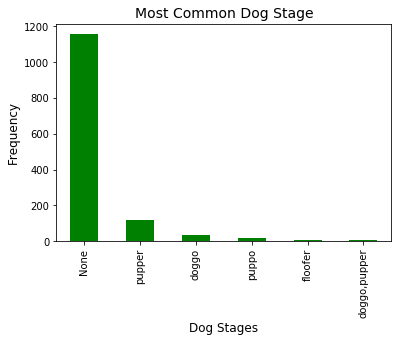

In [67]:
#Create a bar plot of the most common dog stage
twitter.dog_stage.value_counts().plot(kind='bar', color= 'g')
plt.xlabel('Dog Stages', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Most Common Dog Stage', fontsize=14)
plt.show()

#### While most of the dog stages are unknown, pupper is the most commonly known dog stage, followed by doggo and puppo. 

In [68]:
twitter.groupby(['dog_stage', 'rating_numerator'])['rating_numerator'].count()

dog_stage     rating_numerator
None          2                     3
              3                     9
              4                     5
              5                    14
              6                    16
              7                    26
              8                    60
              9                    86
              10                  233
              11                  256
              12                  285
              13                  154
              14                    8
              75                    1
              1776                  1
doggo         8                     2
              10                    1
              11                    8
              12                   10
              13                    8
              14                    6
doggo,pupper  10                    1
              12                    2
              13                    1
floofer       10                    1
              11   

#### Doggo has the highest rating of 12/10 (followed by a tie 11/10 and 13/10). Floofer also has the highest rating of 12/10. Pupper has a rating of 11/10, followed by 10/10. Puppo has a highest rating of 12/10, followed by 13/10. There doesn't seem to be a correlation between dog stages and ratings.

In [69]:
twitter.groupby(['rating_numerator'])['favorite_count'].sum()

rating_numerator
2          7470.0
3         26133.0
4         15881.0
5         79746.0
6         58943.0
7        109577.0
8        161605.0
9        226015.0
10       994633.0
11      1933170.0
12      3683287.0
13      3780631.0
14       529575.0
27         6718.0
75        18784.0
1776       5194.0
Name: favorite_count, dtype: float64

## What is the Relationship between Ratings and the Number of Likes?

#### There is an overall positive correlation between ratings and the number of likes. Generally, the number of likes increases as the ratings increase, especially for ratings 2-13/10.

In [70]:
twitter.groupby(['rating_numerator'])['retweet_count'].sum()

rating_numerator
2         3482.0
3         8944.0
4         4872.0
5        23782.0
6        19550.0
7        37016.0
8        56055.0
9        72888.0
10      332473.0
11      593152.0
12      939806.0
13      985491.0
14      163720.0
27        1661.0
75        6310.0
1776      2491.0
Name: retweet_count, dtype: float64

## What is the Relationship between Ratings and the Number of Retweets?

#### There is an overall positive correlation between ratings and the number of retweets. Generally, the number of retweets increases as the ratings increase, especially for ratings 2-13/10.

## How Does the Number of Likes Vary over Time?

Text(0.5, 1.0, 'Variation in Likes over Time')

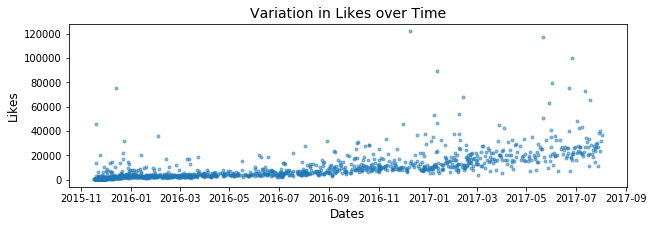

In [71]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot_date(twitter.timestamp, twitter.favorite_count, alpha=0.5, ms=3)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Likes', fontsize=12)
plt.title('Variation in Likes over Time', fontsize=14)

#### The number of Likes steadily increased over time.

## How Does the Number of Retweets Vary over Time?

Text(0.5, 1.0, 'Variation in Retweets over Time')

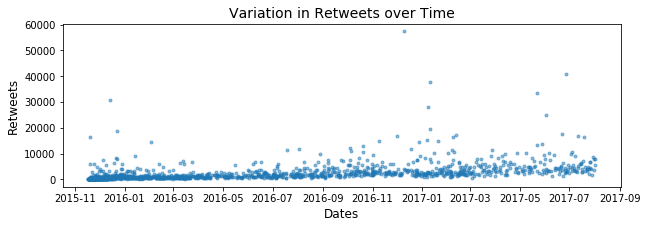

In [72]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot_date(twitter.timestamp, twitter.retweet_count, alpha=0.5, ms=3)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Retweets', fontsize=12)
plt.title('Variation in Retweets over Time', fontsize=14)

#### The number of retweets slightly increased over time but at lower rate than the number of Likes.

## What is the Relation between Retweets & Likes?

C:\Users\Deborah\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


Text(0.5, 1.0, 'Retweets and Likes Scatter Plot')

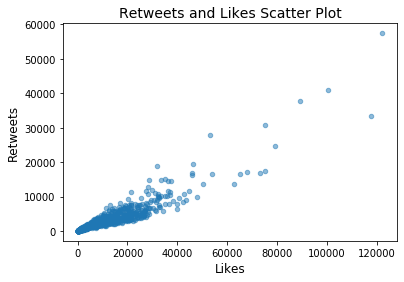

In [73]:
#Retweets vs. Likes
twitter.plot(kind='scatter',x='favorite_count',y='retweet_count', alpha = 0.5)
plt.xlabel('Likes', fontsize=12)
plt.ylabel('Retweets', fontsize=12)
plt.title('Retweets and Likes Scatter Plot', fontsize=14)

#### Retweets are strongly positively correlated with Likes.